In [62]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
#

In [46]:
# Currently data is in directories like

In [47]:
# Try a new CNN with the input data augmented so it will classify obscured spheres
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

#########################################################
# With this the whole file structure had to be changed.
# TODO Use code for test train split, currently the last 10 or so files are used as test, not randomly
#   For test/train split
#       get list of positives and negatives, test/train split the list.
#       move all filenames in that list to either test, or train directory
#########################################################

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,  #
        height_shift_range=0.2, # Incresead these so theyre high so theyll know to classify sphere if only half a sphere is showing
        shear_range=0.2,
        zoom_range=[1,5],
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('TrainingImages/positives/positivePatch_304.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (51, 51, 3)
x = x.reshape((1,) + x.shape)  # np array with shape (1, 51, 51, 3)

# Save example images if you want to see whats happening inside
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='TrainingImages', save_prefix='augmented', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(51, 51, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [49]:
batch_size = 16 # TODO find out what batch_size is

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=[1,5],       # Changed to zoom out
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'TrainingImages/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'TrainingImages/train',  # this is the target directory
        target_size=(51, 51),  # all images will be resized to 51x51
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'TrainingImages/test',
        target_size=(51, 51),
        batch_size=batch_size,
        class_mode='binary')

Found 2830 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


In [50]:
# TODO search more about these hyperparameters
# steps_per_epoch???? 

model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
#model.save_weights('augmentedCNN.h5')  # Maybe save if I find out how to load


Epoch 1/5
125/125 [==============================] - 23s 183ms/step - loss: 0.1268 - accuracy: 0.9635 - val_loss: 0.8855 - val_accuracy: 0.9242
Epoch 2/5
125/125 [==============================] - 16s 124ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.8118 - val_accuracy: 0.9394
Epoch 3/5
125/125 [==============================] - 11s 85ms/step - loss: 0.0163 - accuracy: 0.9985 - val_loss: 0.4580 - val_accuracy: 0.9469
Epoch 4/5
125/125 [==============================] - 11s 88ms/step - loss: 0.0145 - accuracy: 0.9990 - val_loss: 1.7072e-05 - val_accuracy: 0.9899
Epoch 5/5
125/125 [==============================] - 11s 90ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 2.5907e-06 - val_accuracy: 0.9899


In [59]:
# Get first image to classify
import PacMan_functionality as PacMan

global_cloud, spheres_collected = PacMan.startup_scene()
position = np.zeros([3])
angle = np.zeros([3])
image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)

In [65]:
# Define function sliding window
# returns array of windows that I can classify at once
def sliding_window( step_size, image ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    windows = []

    for y in range(0, image_hight-window_size, step_size):   # Verticle?
        for x in range (0, image_width-window_size, step_size):   #horizontal?
            windows.append(image[y:y+window_size, x:x+window_size, :])

    return np.array(windows) # Return windows as np array


res = sliding_window(1, image)
np.shape(res)

(20601, 51, 51, 3)

60
14
[[0.9932115]]


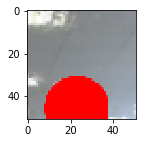

23
[[0.98281133]]


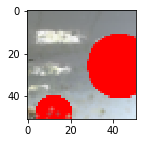

24
[[1.]]


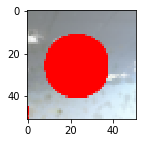

32
[[1.]]


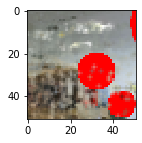

43
[[0.9999982]]


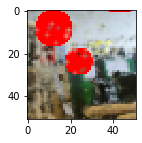

In [71]:
test = sliding_window(20, image)

print(len(test[:,0,0,0]))

#for i in range( len(test[:,0,0,0]) ):
for i in range( test.shape[0] ):
    prediction = model.predict( np.array( [test[i,:,:,:],]) )

    if (prediction > 0.5):  # If prediction is more than 50% confident
        print(i)
        print(prediction)  
        #print( str(prediction).format(1.0e-9) ) # Force scientific notation off
        plt.figure(figsize=(4,2))
        plt.imshow(test[i,:,:,:])    
        plt.show()
        


In [68]:
# Our classifier trained on augmented data works well, but will it classify after i've moved?

position = np.asarray([0, 0, 0])
print('I am at position [{0}, {1}, {2}]'.format(*position))
print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));

# Move position and update scene
position = np.asarray([-0.18, 0.08, 2.31])
print('I am now at position [{0}, {1}, {2}]'.format(*position))
global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));

I am at position [0.0, 0.0, 0.0]
I have found 0 out of 11 spheres!

I am now at position [-0.18, 0.08, 2.31]
I have found 1 out of 11 spheres!



In [74]:
# Now gwt images from that view, plot, then classify them?
image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)
plt.figure(figsize=(2,2))
plt.imshow(image)
test = sliding_window(20, image)

for i in range( len(test[:,0,0,0]) ):
    
    prediction = model.predict( np.array( [test[i,:,:,:],]) )

    if (confidence_threshold(prediction)==True):
        print(i)
        print(prediction)
        #print( str(prediction).format(1.0e-9) ) # Force scientific notation off
        plt.figure(figsize=(4,2))
        plt.imshow(test[i,:,:,:])    
        plt.show()

In [0]:
# Move to next sphere and update

In [0]:
#

In [0]:
#

In [0]:
#

In [0]:
#
#

In [0]:
#

In [0]:
#